,date,sales
186,2021-12-01,1484517.22
5130,2021-11-01,1201275.35
5129,2021-10-01,1282952.27
5128,2021-09-01,1186563.47
5127,2021-08-01,1050841.48
5126,2021-07-01,857864.14
5125,2021-06-01,809645.29
5124,2021-05-01,861330.31
5123,2021-04-01,1097800.27
5122,2021-03-01,1281469.39


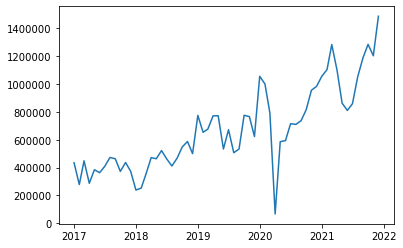

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor

from sklearn.model_selection import KFold, cross_val_score, train_test_split

from scipy import stats

import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tools.eval_measures import rmse

import pickle
import warnings

pd.options.display.float_format = '{:.2f}'.format
pd.options.display.max_rows = 1000

warnings.filterwarnings("ignore")

data = pd.read_csv('datasets/sales_data.csv')
data['date'] =  pd.to_datetime(data['date'])

data = data[(data.business_area_id==3) & (data.country_id==12)].sort_values(by='date',ascending =False)
data.rename(columns={"revenue": "sales"}, inplace=True)

monthly_df = data[['date','sales']]


display(monthly_df.head(10))
monthly_df.to_csv('train.csv')

plt.ticklabel_format(style='plain')
x = monthly_df['date']
y = monthly_df['sales']
plt.plot(x, y)

In [2]:
def get_diff(data):
    data['sales_diff'] = data.sales.diff()
    data = data.dropna()
    
    data.to_csv('stationary_df.csv')
    return data

stationary_df = get_diff(monthly_df)
stationary_df.head()

,date,sales,sales_diff
5130,2021-11-01,1201275.35,-283241.86
5129,2021-10-01,1282952.27,81676.92
5128,2021-09-01,1186563.47,-96388.80
5127,2021-08-01,1050841.48,-135721.99
5126,2021-07-01,857864.14,-192977.35


In [3]:
#create dataframe for transformation from time series to supervised
def generate_supervised(data):
    supervised_df = data.copy()
    
    #create column for each lag
    for i in range(1,13):
        col_name = 'lag_' + str(i)
        supervised_df[col_name] = supervised_df['sales_diff'].shift(i)
    
    #drop null values
    supervised_df = supervised_df.dropna().reset_index(drop=True)
    
    supervised_df.to_csv('model_df.csv', index=False)
    
    return supervised_df

model_df = generate_supervised(stationary_df)
model_df.head(5)

,date,sales,sales_diff,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
0,2020-11-01,954211.29,-27396.65,-72044.56,-48859.35,-178957.54,183669.12,236469.96,51685.02,-48218.85,-192977.35,-135721.99,-96388.80,81676.92,-283241.86
1,2020-10-01,814215.92,-139995.37,-27396.65,-72044.56,-48859.35,-178957.54,183669.12,236469.96,51685.02,-48218.85,-192977.35,-135721.99,-96388.80,81676.92
2,2020-09-01,736039.41,-78176.51,-139995.37,-27396.65,-72044.56,-48859.35,-178957.54,183669.12,236469.96,51685.02,-48218.85,-192977.35,-135721.99,-96388.80
3,2020-08-01,709306.02,-26733.39,-78176.51,-139995.37,-27396.65,-72044.56,-48859.35,-178957.54,183669.12,236469.96,51685.02,-48218.85,-192977.35,-135721.99
4,2020-07-01,714395.03,5089.01,-26733.39,-78176.51,-139995.37,-27396.65,-72044.56,-48859.35,-178957.54,183669.12,236469.96,51685.02,-48218.85,-192977.35


In [4]:
def tts(data):
    data = data.drop(['sales','date'],axis=1)
    train, test = data[0:-12].values, data[-12:].values
    
    return train, test

train, test = tts(model_df)

In [5]:
train.shape

(35, 13)

In [6]:
test.shape

(12, 13)

In [7]:
def scale_data(train_set, test_set):
    #apply Min Max Scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train_set)
    
    # reshape training set
    train_set = train_set.reshape(train_set.shape[0], train_set.shape[1])
    train_set_scaled = scaler.transform(train_set)
    
    # reshape test set
    test_set = test_set.reshape(test_set.shape[0], test_set.shape[1])
    test_set_scaled = scaler.transform(test_set)
    
    X_train, y_train = train_set_scaled[:, 1:], train_set_scaled[:, 0:1].ravel()
    X_test, y_test = test_set_scaled[:, 1:], test_set_scaled[:, 0:1].ravel()
    
    return X_train, y_train, X_test, y_test, scaler

X_train, y_train, X_test, y_test, scaler_object = scale_data(train, test)

In [8]:
y_train.shape

(35,)

In [9]:
def undo_scaling(y_pred, x_test, scaler_obj, lstm=False):  
    #reshape y_pred
    y_pred = y_pred.reshape(y_pred.shape[0], 1, 1)
    
    if not lstm:
        x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])
    
    #rebuild test set for inverse transform
    pred_test_set = []
    for index in range(0,len(y_pred)):
        pred_test_set.append(np.concatenate([y_pred[index],x_test[index]],axis=1))
        
    #reshape pred_test_set
    pred_test_set = np.array(pred_test_set)
    pred_test_set = pred_test_set.reshape(pred_test_set.shape[0], pred_test_set.shape[2])
    
    #inverse transform
    pred_test_set_inverted = scaler_obj.inverse_transform(pred_test_set)
    
    return pred_test_set_inverted

In [10]:
def load_original_df():
    #load in original dataframe without scaling applied
    original_df = pd.read_csv('train.csv')
    original_df.date = original_df.date.apply(lambda x: str(x)[:-3])
    original_df = original_df.groupby('date')['sales'].sum().reset_index()
    original_df.date = pd.to_datetime(original_df.date)
    return original_df

In [11]:
def predict_df(unscaled_predictions, original_df):
    #create dataframe that shows the predicted sales
    result_list = []
    sales_dates = list(original_df[-13:].date)
    act_sales = list(original_df[-13:].sales)
    
    for index in range(0,len(unscaled_predictions)):
        result_dict = {}
        result_dict['pred_value'] = int(unscaled_predictions[index][0] + act_sales[index])
        result_dict['date'] = sales_dates[index+1]
        result_list.append(result_dict)
        
    df_result = pd.DataFrame(result_list)
    
    return df_result

In [12]:
model_scores = {}

def get_scores(unscaled_df, original_df, model_name):
    rmse = np.sqrt(mean_squared_error(original_df.sales[-12:], unscaled_df.pred_value[-12:]))
    mae = mean_absolute_error(original_df.sales[-12:], unscaled_df.pred_value[-12:])
    r2 = r2_score(original_df.sales[-12:], unscaled_df.pred_value[-12:])
    model_scores[model_name] = [rmse, mae, r2]

    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"R2 Score: {r2}")

In [13]:
def plot_results(results, original_df, model_name):

    plt.ticklabel_format(style='plain')
    fig, ax = plt.subplots(figsize=(15,5))
    sns.lineplot(original_df.date, original_df.sales, data=original_df, ax=ax, 
                 label='Original', color='mediumblue')
    sns.lineplot(results.date, results.pred_value, data=results, ax=ax, 
                 label='Predicted', color='Red')
    
    ax.set(xlabel = "Date",
           ylabel = "Sales",
           title = f"{model_name} Sales Forecasting Prediction")
    
    ax.legend()
    
    sns.despine()
    
    plt.savefig(f'{model_name}_forecast.png')

In [14]:
def run_model(train_data, test_data, model, model_name):
    
    X_train, y_train, X_test, y_test, scaler_object = scale_data(train_data, test_data)
    
    mod = model
    mod.fit(X_train, y_train)
    predictions = mod.predict(X_test)
    
    # Undo scaling to compare predictions against original data
    original_df = load_original_df()
    unscaled = undo_scaling(predictions, X_test, scaler_object)
    unscaled_df = predict_df(unscaled, original_df)
      
    get_scores(unscaled_df, original_df, model_name)
    
    plot_results(unscaled_df, original_df, model_name)

# Linear Regression

RMSE: 186950.4731467143
MAE: 161787.0305666667
R2 Score: 0.03820901418626921


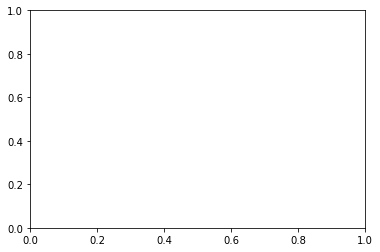

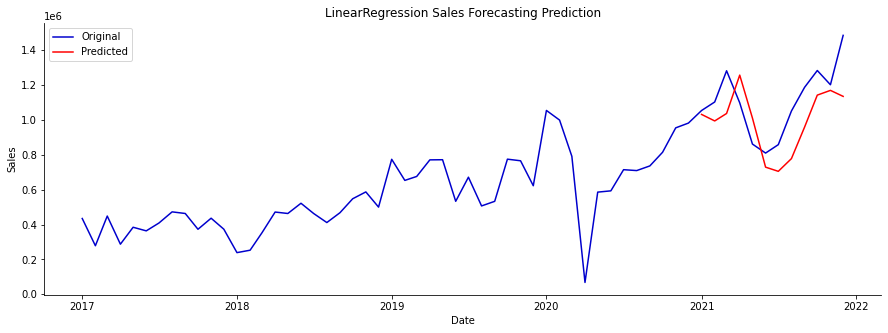

In [15]:
run_model(train, test, LinearRegression(), 'LinearRegression')

# Random Forest Regressor

RMSE: 163308.14242604302
MAE: 137148.75715
R2 Score: 0.2660892604304599


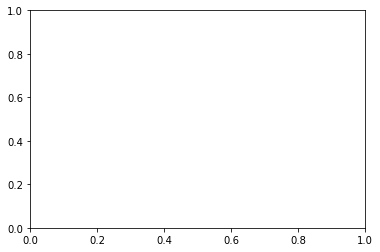

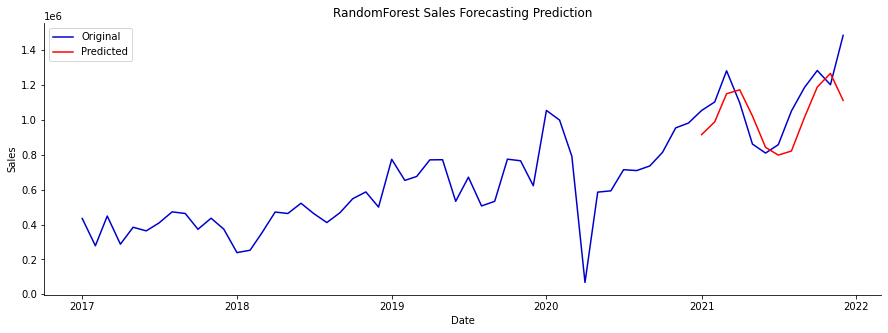

In [16]:
run_model(train, test, RandomForestRegressor(n_estimators=100, max_depth=20), 'RandomForest')

# XGBoost

RMSE: 174075.44412327107
MAE: 141976.2215666667
R2 Score: 0.16612186020785347


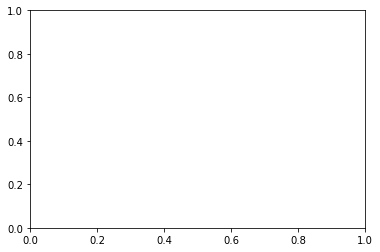

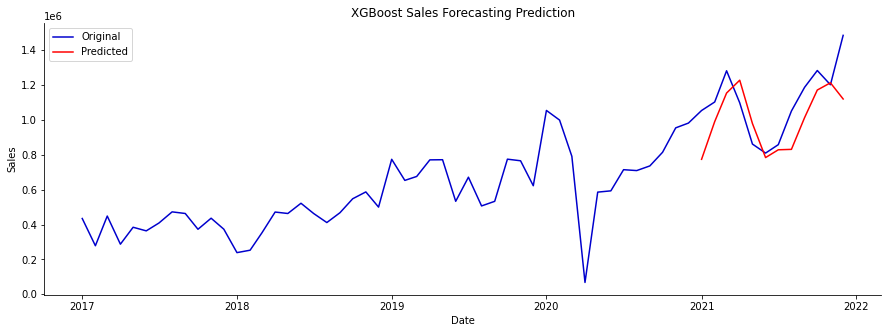

In [17]:
run_model(train, test, XGBRegressor( n_estimators=100, learning_rate=0.2, objective='reg:squarederror'), 'XGBoost')

In [18]:
pickle.dump(model_scores, open( "model_scores.p", "wb" ) )

In [19]:
def create_results_df():
    results_dict = pickle.load(open("model_scores.p", "rb"))
    
    #results_dict.update(pickle.load(open("arima_model_scores.p", "rb")))
    
    restults_df = pd.DataFrame.from_dict(results_dict, orient='index', 
                                        columns=['RMSE', 'MAE','R2'])
    
    restults_df = restults_df.sort_values(by='RMSE', ascending=False).reset_index()
    
    return restults_df

In [20]:
results = create_results_df()
results

,index,RMSE,MAE,R2
0,LinearRegression,186950.47,161787.03,0.04
1,XGBoost,174075.44,141976.22,0.17
2,RandomForest,163308.14,137148.76,0.27


In [21]:
def plot_results(results_df):
    fig, ax = plt.subplots(figsize=(12, 5))
    sns.lineplot(np.arange(len(results_df)), 'RMSE', data=results_df, ax=ax, 
                 label='RMSE', color='mediumblue')
    sns.lineplot(np.arange(len(results_df)), 'MAE', data=results_df, ax=ax, 
                 label='MAE', color='Cyan')
    
    plt.xticks(np.arange(len(results_df)),rotation=45)
    ax.set_xticklabels(results_df['index'])
    ax.set(xlabel = "Model",
           ylabel = "Scores",
           title = "Model Error Comparison")
    sns.despine()
    
    plt.savefig(f'compare_models.png')

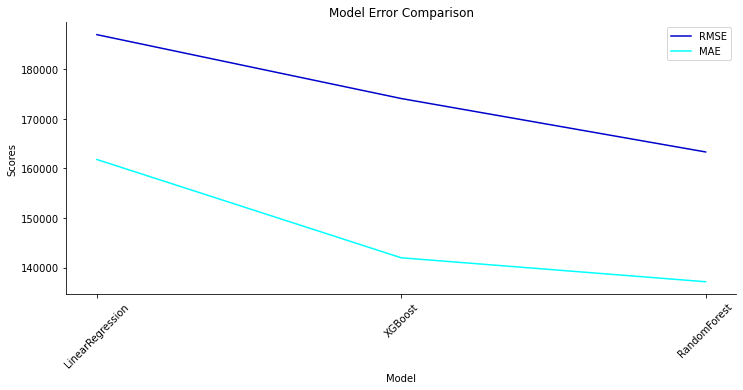

In [22]:
plot_results(results)